## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from pandasql import sqldf
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
# %load_ext autoreload
# %autoreload 2

## Read data

In [3]:
products_df = pd.read_parquet('data/products.parquet', engine='fastparquet')
reasons_df = pd.read_parquet('data/return_reasons.parquet', engine='fastparquet')
returns_df = pd.read_parquet('data/returns.parquet', engine='fastparquet')
reviews_df = pd.read_parquet('data/reviews.parquet', engine='fastparquet')

In [4]:
test_df = pd.read_parquet('data/test.parquet', engine='fastparquet')

In [5]:
reason_encoder = LabelEncoder()
returns_df['enc_cause'] = reason_encoder.fit_transform(returns_df.cause)

In [18]:
reviews_df

,order_item_id,product_id,customer_id,review_text,shop_id,rating,date_created
0,19068657,641695ab1f06465947d1e4e26f61ed308145dce718d9b6...,0aaefdb4bd01799d678f7fcd453e23c597804eb006f1ce...,товар потерян,c2f61742e5f0ef0a74c5fcbeff7ff659def91bf4b5f1e1...,1,2023-10-17 17:26:42.874
1,11130626,2c0818e03896a3e27fd8ec01ba9d7ae80d97673575a847...,851513a761b89239303515254d0e9c22a8474dd2df60b8...,,757db91a80964d58a2b0d26bffd641bcbe142aae4f7f47...,5,2023-07-27 10:06:40.711
2,8992153,d00a0a981e5618c4f96802e79c205ef2175b141edff368...,96659e77ab5e9b52ecbf110eed661c3fe742fc42443d50...,,8f0f97e140e126a4404a09eb1e14a53b7c742701c4290a...,5,2023-07-03 14:47:59.316
3,11078898,d0d9bad11fa6fedcf5c699055137a36f4c4c81d722b5fd...,321667e5d0ada2fa7f2356076f88a3848e596cde7bd120...,"Rahmat, juda yoqdi!",61182f39851829ca78c919a83ecbfa045fc0686bff16d0...,5,2023-07-30 12:26:59.864
4,32080499,4edd99b2e2a203a18cf24b6a2b134833ef1f74cf1940c0...,d67c451b69c7f706cedf6d4a87f1180ea62acd57c94a29...,16гб работает хорошо,02cca3803b564ede11ccf9f303c9910b39c532061e7a8c...,5,2024-01-19 06:02:57.971
...,...,...,...,...,...,...,...
1502884,32348858,39c3641b870885de48dc1fc97854dd353406db32616399...,a6bbaaa7fa9ef4f0c02e58b6696389670b0078261d4406...,хороший хайлайтер,aa1afcfd3a19edd5b93b95bdab4decab5a56bea75872ef...,4,2024-01-20 13:06:46.772
1502885,29592084,36a26cfc685fc9561a75526ecf191b162a838e1584177a...,b69d48516ce69d91633f8b149b713d1edca56b3feadca6...,128 ГБ олгандим лекин жойи кам нима учун?,10817df0e1576683281c68a35157e456c39ec64bd3887c...,3,2024-01-18 18:25:38.751
1502886,26088909,4852ee6bcb8c845dcb570a953f5b902ee7237b8053e214...,6784ba978ead3d15b9317229d5458b02ad41d8b62fb02e...,,aaf01d71b55e51b1a3051cbb3cdc0646578dcda722b292...,4,2023-12-10 15:53:34.110
1502887,27068118,0d2be62dc6d4e741fa5d7381922928e8e3b83127f6f095...,a414cddb89d238d056a6113cd84f1aeaddf2fd9052d85e...,,6e17f7196e0c75a2c25d475dd9239dc4f3f6a5047a18e1...,4,2023-12-16 13:03:02.448


## Distribution of return reasons

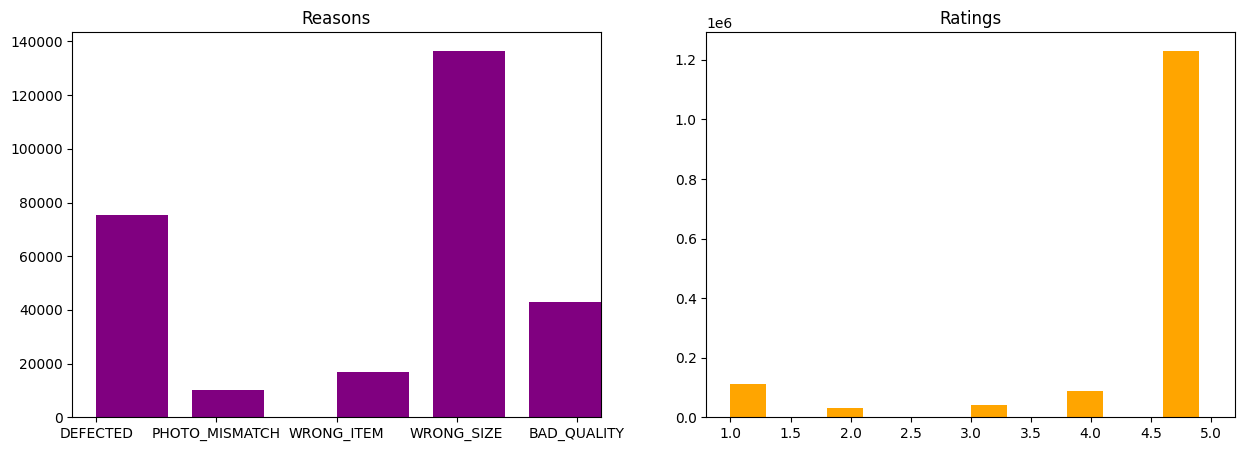

In [7]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.hist(returns_df.cause, width=0.6, color='purple');
ax.set_title('Reasons')
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Ratings')
plt.hist(reviews_df.rating, width=0.3, color='orange');

## Data of each customer average rating

In [8]:
customers_ratings = sqldf(
    '''
    SELECT customer_id,
           avg(rating )as customer_avg_rating
      FROM reviews_df
    GROUP BY customer_id
    '''
)

## Data of each product average rating

In [9]:
product_ratings = sqldf(
    '''
    SELECT product_id,
           avg(rating) as product_avg_rating
      FROM reviews_df
    GROUP BY product_id
    '''
)

## Apply M-BERT feature selection to reviews

In [10]:
reviews = reviews_df['review_text']
reviews = reviews.to_numpy()
reviews

array(['товар потерян', '', '', ..., '', '',
       'Uzum marketka rahmat zoʻr ekan'], dtype=object)

In [11]:
from nltk import 

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# model_name = 'bert-base-multilingual-cased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)

# cls_embeddings = []
# BATCH_SIZE = 1000


# for i in tqdm(range(0, len(reviews), BATCH_SIZE)):
#     batch_reviews = reviews[i:i+BATCH_SIZE]
#     enc_batch = tokenizer.batch_encode_plus(batch_reviews, return_tensors='pt', add_special_tokens=True, padding=True)
    
#     with torch.inference_mode():
#         output = model(**enc_batch)

#     cls_embeddings.append(output.pooler_output)

  0%|▍                                                                                | 7/1503 [03:00<10:44:26, 25.85s/it]


KeyboardInterrupt: 

## Create train dataset to fit our model

In [75]:
train_df = sqldf(
    '''
    SELECT ret.id,
           ret.enc_cause as target,
           ret.purchase_price as price,
           cr.customer_avg_rating,
           pr.product_avg_rating
      FROM returns_df ret
      LEFT JOIN customers_ratings as cr 
        ON cr.customer_id = ret.customer_id
      LEFT JOIN product_ratings as pr 
        ON pr.product_id = ret.product_id
    '''
)

In [87]:
train_df.fillna(-1, inplace=True)
train_df

,id,target,price,customer_avg_rating,product_avg_rating
0,69138,1,106000,-1.000000,4.000000
1,69148,2,23000,-1.000000,4.776596
2,69154,1,390000,1.000000,4.035714
3,69161,3,71000,3.000000,1.000000
4,69165,1,84000,4.333333,4.666667
...,...,...,...,...,...
282136,3819180,4,544000,4.619048,5.000000
282137,3819181,4,199000,4.619048,5.000000
282138,3819447,4,114000,3.000000,4.840909
282139,3819467,2,87000,-1.000000,4.750000
